In [ ]:
# Alexander Nechyporenko
# 15ann2
# 20021759

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statistics

from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from scipy.stats import shapiro
from scipy.fftpack import dct
from sklearn.metrics import mean_absolute_error

from google.colab import files
import io

In [ ]:
# upload the dervide data retrieved from computesequences in Matlab
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['derive_data.csv']))
data = pd.DataFrame(df)

# Name the column data
data.columns = ['Real Base', 'Base', 'Der 1', 'Der 2', 'Days']
historical_set = 10

Saving derive_data.csv to derive_data (1).csv


In [ ]:
# Retrieve the DCT data that is used as input from the computesequences file in Matlab
dct_conversion = dct(data['Real Base'].to_numpy(), type=1)

data.insert(4, 'Der 3', dct_conversion)

In [ ]:
# Taking the 3 derivation columns, apply the SVD transformation to the data
derive = data[['Der 1', 'Der 2', 'Der 3']].values

svd = TruncatedSVD(algorithm='arpack')
svd_features = svd.fit_transform(derive)

print(derive)
print(svd_features)

[[  169.86         217.76         463.89542484]
 [  165.61         213.           483.60798325]
 [  164.59         211.31         510.07536136]
 ...
 [  171.58         220.33        -465.59155634]
 [  169.39         218.28        -797.52418492]
 [  162.9          211.69       -2379.53962084]]
[[ 272.27424143 -466.1944709 ]
 [ 265.74321722 -485.85274835]
 [ 263.56090192 -512.30287515]
 ...
 [ 283.15049485  463.23398491]
 [ 282.97094156  795.17997826]
 [ 287.04766399 2377.21717255]]


In [ ]:
gaussian_features = []

# remove columsn that satisfy the gaussian distribution metric and then apply ICA to the remaining data
derive_df = data[['Der 1', 'Der 2', 'Der 3']]
for name, values in derive_df.iteritems():
  # If gaussian distribution, then append feature name to remove later
  if not shapiro(values)[1] < 0.05:
    gaussian_features.append(name)

derive_df = derive_df.drop(columns=gaussian_features)

cpts = 3
ica = FastICA(algorithm='parallel',  
              whiten=True,
              max_iter=cpts,
              fun='exp',
              tol=1E-3)

ica_transform = ica.fit_transform(derive_df.to_numpy())
print(derive_df)
print(ica_transform)

       Der 1   Der 2          Der 3
0     169.86  217.76  291050.400000
1     165.61  213.00     732.530297
2     164.59  211.31    1068.640475
3     170.32  216.81    -236.672933
4     175.20  223.31      55.107287
...      ...     ...            ...
2258  173.49  221.41    -621.341933
2259  173.73  221.92     835.727120
2260  171.58  220.33    1879.494814
2261  169.39  218.28     239.534067
2262  162.90  211.69    1070.400000

[2263 rows x 3 columns]
[[-9.81722155e-01 -6.29174600e-02  4.59990198e-02]
 [-2.37496717e-03 -8.40378856e-03 -1.74952340e-02]
 [-3.28170320e-03 -1.17813437e-02 -1.69194219e-02]
 ...
 [-5.84226491e-03 -1.03741959e-02 -1.09239861e-02]
 [-8.88317012e-04 -4.15375253e-03 -1.59015289e-02]
 [-5.06720554e-03  9.04773207e-03 -2.76541737e-02]]


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


In [ ]:
# compile transformed data to use as input SVM prediction
for i in range(len(svd_features[0,:])):
  column_name = 'SVD ' + str(i + 1)
  data[column_name] = svd_features[:, i]

for i in range(len(ica_transform[0,:])):
  column_name = 'ICA ' + str(i + 1)
  data[column_name] = ica_transform[:, i]

# After we compile all of the transformed data, we place it into SVM input. Meaning
# this data can now be used as input into predictsvm Matlab file to run the models
print(data)
data.to_csv('SVM_input.csv', encoding='utf-8', index=False, header=False)

      Real Base    Base   Der 1   Der 2        Der 3  Days       SVD 1  \
0          56.0  55.400  169.86  217.76   463.895425     5  272.274241   
1          61.0  54.000  165.61  213.00   483.607983     6  265.743217   
2          57.0  55.400  164.59  211.31   510.075361     0  263.560902   
3          59.0  61.800  170.32  216.81   839.558524     1  268.656563   
4          76.0  64.200  175.20  223.31  1192.131879     2  273.827804   
...         ...     ...     ...     ...          ...   ...         ...   
2258       80.0  59.000  173.49  221.41  -283.767582     2  283.650321   
2259       49.0  59.600  173.73  221.92  -366.626514     3  284.894944   
2260       52.0  57.600  171.58  220.33  -465.591556     4  283.150495   
2261       47.0  56.800  169.39  218.28  -797.524185     5  282.970942   
2262       56.0  51.667  162.90  211.69 -2379.539621     6  287.047664   

            SVD 2     ICA 1     ICA 2     ICA 3  
0     -466.194471  0.115905  0.016962 -0.037713  
1     -485.

In [ ]:
# This section runs the Kingston data that will be used for the histogram nudging

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['prediction_results.csv'])) # kingston
results = pd.DataFrame(df)

uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['amount_kingston.csv'])) # without transformed data from python
df = pd.read_csv(io.BytesIO(uploaded['amount_kingston_transformed.csv'])) # kingston
patient_count = pd.DataFrame(df)

# This section runs the Windsor data that will be used for the histogram nudging
# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['prediction_results_windsor.csv'])) # windsor
# results = pd.DataFrame(df)

# uploaded = files.upload()
# # df = pd.read_csv(io.BytesIO(uploaded['amount_kingston.csv'])) # without transformed data from python
# df = pd.read_csv(io.BytesIO(uploaded['amount_windsor_transformed.csv'])) # windsor
# patient_count = pd.DataFrame(df)

patient_count = patient_count['Count'].to_numpy()

Saving prediction_results.csv to prediction_results (1).csv


Saving amount_kingston_transformed.csv to amount_kingston_transformed (1).csv


Histogram Adjustment length comparison to label data: 2253 vs. 2253
MAE mean with adjusted values from histogram: 3.885400621393697
MAE mean with adjusted values without histogram: 3.907804527296937


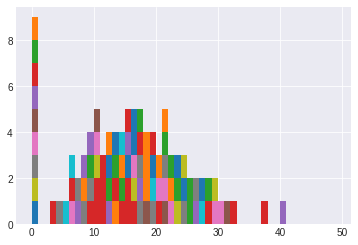

In [ ]:
# histogram adjustment
max_patient_count = 30
hist_weight_adj = 0.5
historical_set = 10

assert not results['YHat'].isnull().values.any(), "YHat must not contain empty values"


# This section of the code runs the histogram nudging and then displays the MAE scores of before and after

patien_set = patient_count[:historical_set] # set initial historical data

(n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 2, 1))

hist_adjusted_results = []

# In a for loop, we go through each prediction and then make nudges based on the histogram plot points
for i in range(len(patient_count) - historical_set):
  patien_set = patient_count[i:historical_set + i]
  (n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 10, 1))

  # if the predicted result is greater than all histogram day counts
  if round(results['YHat'][i]) >= len(n):
    # I attempted a histogram adjustment via continuously looking for the first none
    # zero n point and then adjust the prediction by a fraction of the difference
    index = len(n) - 1
    while n[index] == 0:
      index -= 1

      if index == 0:
        break
    shift = n[index] * hist_weight_adj
    hist_adjusted_results.append(results['YHat'][i] - 1)

  # If the prediction has zero accurances in the last 10 days, we go into this statement
  elif n[round(results['YHat'][i])] == 0:
      left = right = round(results['YHat'][i])

      # we determine in which direction the nearest counts are and nudge in that direction
      item = round(results['YHat'][i])
      if item - 1 < 0:
        if item + 1 <= len(n) and n[item + 1] > 0:
          hist_adjusted_results.append(results['YHat'][i] + 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])
      elif item + 1 >= len(n):
        if item - 1 > 0 and n[item - 1] > 0:
          hist_adjusted_results.append(results['YHat'][i] - 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])
      # if prediction is within confines of the histogram, then make nudges based on that
      else:
        # Which ever side is greater, we nudge in that direction when we find our
        # nearest neighbours with values
        if n[item - 1] > n[item + 1]:
          shift = item * hist_weight_adj
          hist_adjusted_results.append(results['YHat'][i] - 1)
        elif n[item - 1] < n[item + 1]:
          shift = item * hist_weight_adj
          hist_adjusted_results.append(results['YHat'][i] + 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])


      
  # If current prediction is less than one of its neighbours, we go into this conditional
  elif n[round(results['YHat'][i])] < n[round(results['YHat'][i]) - 1] or n[round(results['YHat'][i])] < n[round(results['YHat'][i]) + 1]:
    left_diff = abs(n[round(results['YHat'][i])] - n[round(results['YHat'][i]) - 1])
    right_diff = abs(n[round(results['YHat'][i])] - n[round(results['YHat'][i]) + 1])

    # we determine which side is the greater one
    if left_diff >= right_diff:
      # change to neighbour if it meets a certain threshold difference
      if left_diff > 3:
        hist_adjusted_results.append(results['YHat'][i] - 1)
      else:
        hist_adjusted_results.append(results['YHat'][i])
    elif right_diff > left_diff:
      if right_diff > 3:
        hist_adjusted_results.append(results['YHat'][i] + 1)
      else:
        hist_adjusted_results.append(results['YHat'][i])
    else:
      hist_adjusted_results.append(results['YHat'][i])
  else:
    hist_adjusted_results.append(results['YHat'][i])
        


print('Histogram Adjustment length comparison to label data: ' + str(len(hist_adjusted_results)) + " vs. " + str(len(results['Label'])))
assert len(hist_adjusted_results) == len(results['Label'])
print('MAE mean with adjusted values from histogram: ' + str(mean_absolute_error(results['Label'], hist_adjusted_results)))
print('MAE mean with adjusted values without histogram: ' + str(mean_absolute_error(results['Label'], results['YHat'])))

Histogram Adjustment length comparison to label data: 2262 vs. 2262
MAE mean with adjusted values from histogram: 2.310891954022989
MAE mean with adjusted values without histogram: 2.3073658709106986


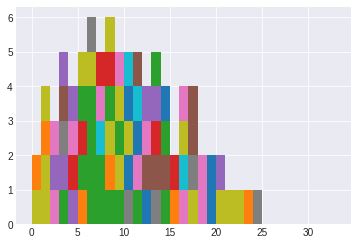

In [ ]:
# Alternative solution for histogram nudging

mean_bound_adjust = True

# histogram adjustment
max_patient_count = 30
hist_weight_adj = 0.5
historical_set = 10

assert not results['YHat'].isnull().values.any(), "YHat must not contain empty values"

# derive error of margin dict
margin_err = []
margin_err_dict = {}

for i in range(len(results)):
  diff = abs(results['Label'][i] - results['YHat'][i])
  margin_err.append(diff)

for i in range(len(results)):
  if results['Label'][i] in margin_err_dict:
    margin_err_dict[results['Label'][i]].append(results['YHat'][i] - results['Label'][i])
  else:
    margin_err_dict[results['Label'][i]] = [results['YHat'][i] - results['Label'][i]]


for day, error_list in margin_err_dict.items():
  mean = statistics.mean(error_list)
  margin_err_dict[day] = mean

# get lowest margin of error patient intakes
low_margin = list(filter(lambda x: 0 < margin_err_dict[x] < 1, margin_err_dict))[0]

# set upper and lower bounds around low margin of errors
upper_bound = low_margin + 5
lower_bound = low_margin - 5

patien_set = patient_count[:historical_set] # set initial historical data

(n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 2, 1))

hist_adjusted_results = []

# iterate over each prediction, if value is above or below threshold then we adjust it
for i in range(len(patient_count) - historical_set):
  patien_set = patient_count[i:historical_set + i]
  (n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 10, 1))

  if mean_bound_adjust:
    # if value is too high or low, then it is more likely to be less accurate, therefore we judge it based on the mean of the previous 10 days
    if round(results['YHat'][i]) > upper_bound or round(results['YHat'][i]) < lower_bound:
      mids = 0.5*(bins[1:] + bins[:-1])
      probs = n / np.sum(n)

      mean = np.sum(probs * mids)  
      if round(results['YHat'][i]) > upper_bound:
        if mean + 5 < results['YHat'][i]:
          hist_adjusted_results.append(results['YHat'][i] - 3)
        elif mean < results['YHat'][i]: 
          hist_adjusted_results.append(results['YHat'][i] - 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])

      else:
        if mean + 5 < results['YHat'][i]:
          hist_adjusted_results.append(results['YHat'][i] + 3)
        elif mean < results['YHat'][i]: 
          hist_adjusted_results.append(results['YHat'][i] + 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])

    else:
      hist_adjusted_results.append(results['YHat'][i])



print('Histogram Adjustment length comparison to label data: ' + str(len(hist_adjusted_results)) + " vs. " + str(len(results['Label'])))
assert len(hist_adjusted_results) == len(results['Label'])
print('MAE mean with adjusted values from histogram: ' + str(mean_absolute_error(results['Label'], hist_adjusted_results)))
print('MAE mean with adjusted values without histogram: ' + str(mean_absolute_error(results['Label'], results['YHat'])))

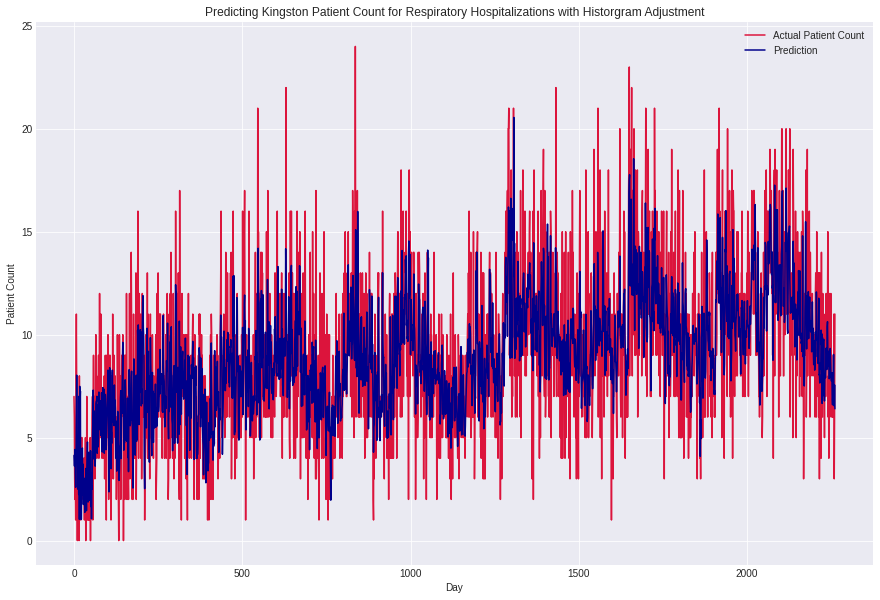

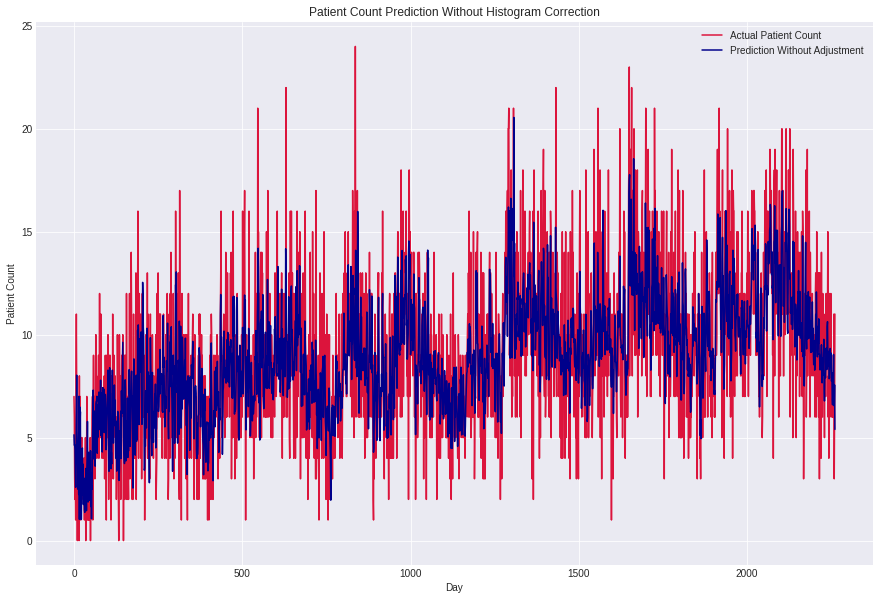

In [ ]:
# These two plots display the contrast between the predicted and actual patient counts. It
# displays both with or without histogram adjustments

plt.figure(figsize=(15,10))
plt.style.use(['seaborn-darkgrid'])
plt.plot(results['Label'], color="crimson", label="Actual Patient Count")
plt.plot(hist_adjusted_results, color="darkblue", label="Prediction")

plt.xlabel("Day")
plt.ylabel("Patient Count")
plt.title("Predicting Kingston Patient Count for Respiratory Hospitalizations with Historgram Adjustment")
plt.legend(loc="upper right")

plt.figure(figsize=(15,10))
plt.style.use(['seaborn-darkgrid'])
plt.plot(results['Label'], color="crimson", label="Actual Patient Count")
plt.plot(results['YHat'], color="darkblue", label="Prediction Without Adjustment")

plt.xlabel("Day")
plt.ylabel("Patient Count")
plt.title("Patient Count Prediction Without Histogram Correction")
plt.legend(loc="upper right")


plt.show()

range(0, 2262)


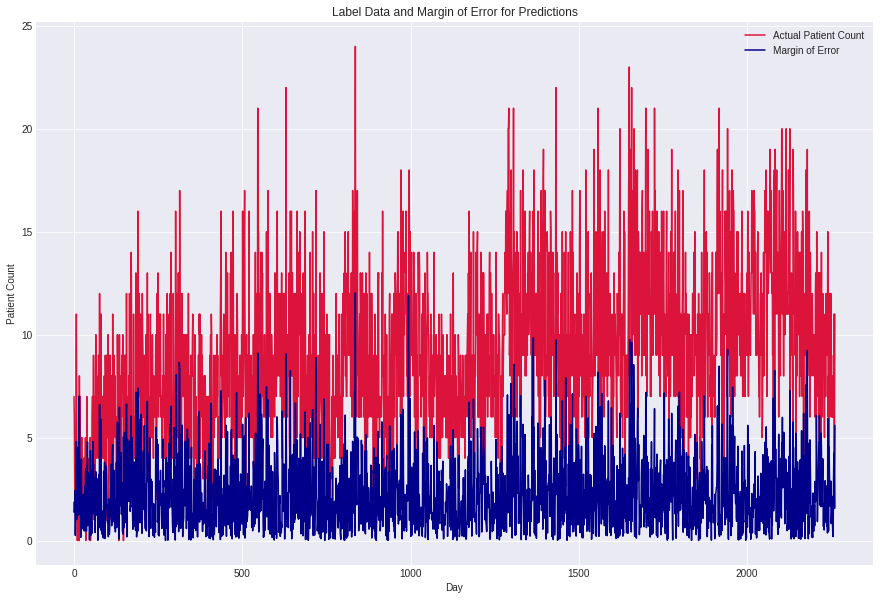

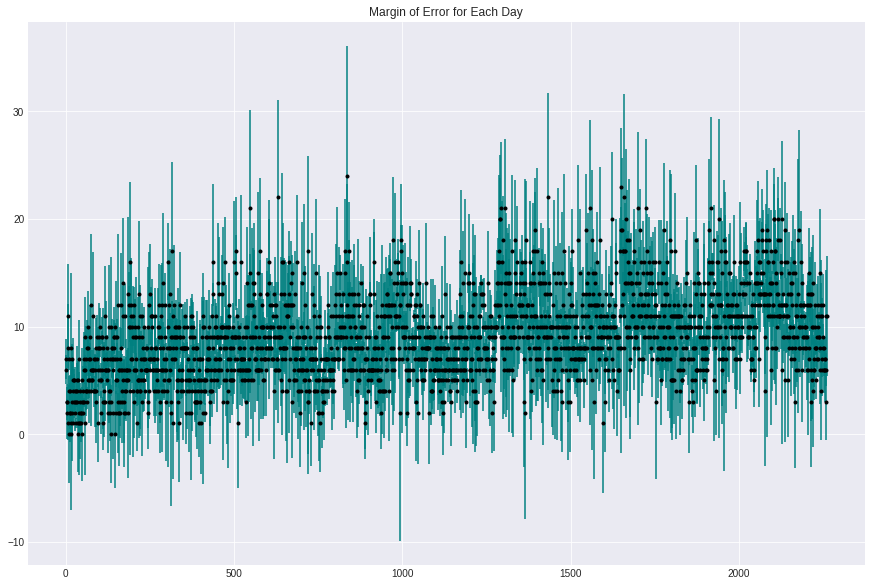

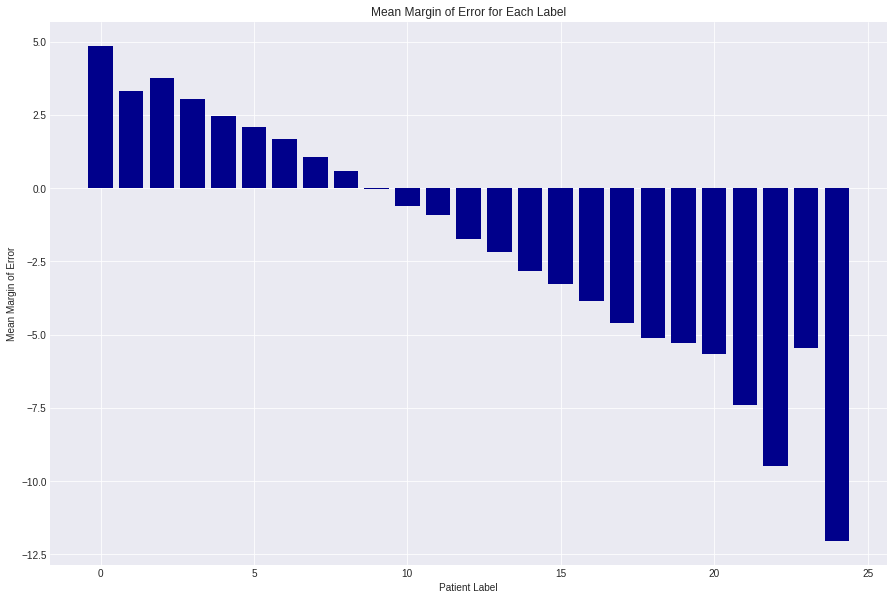

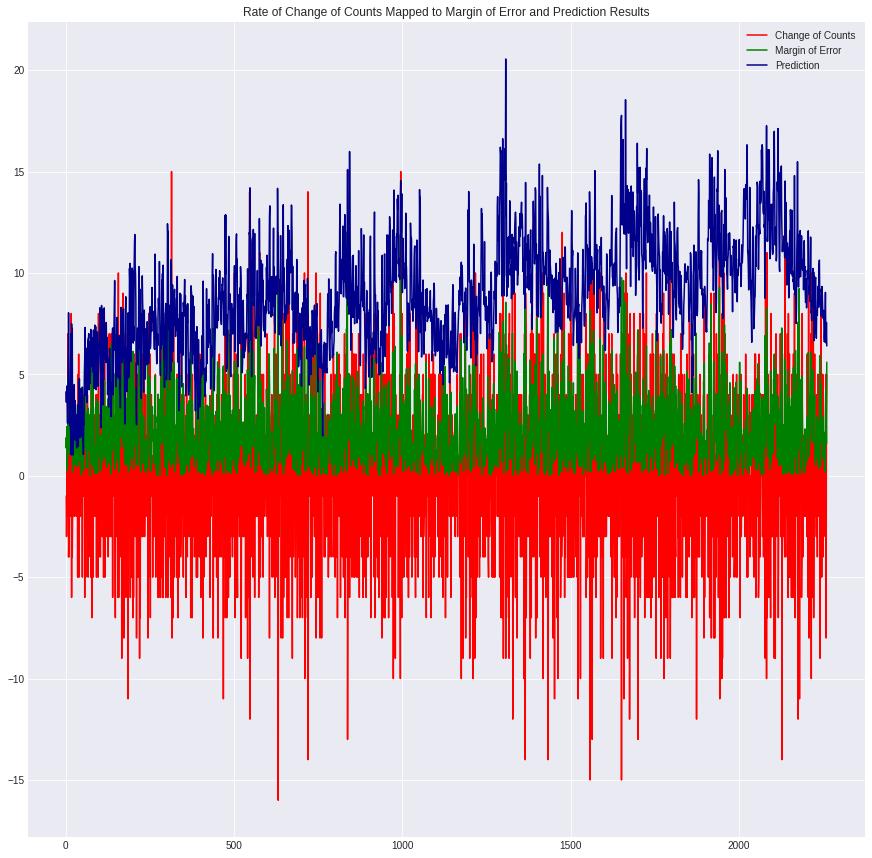

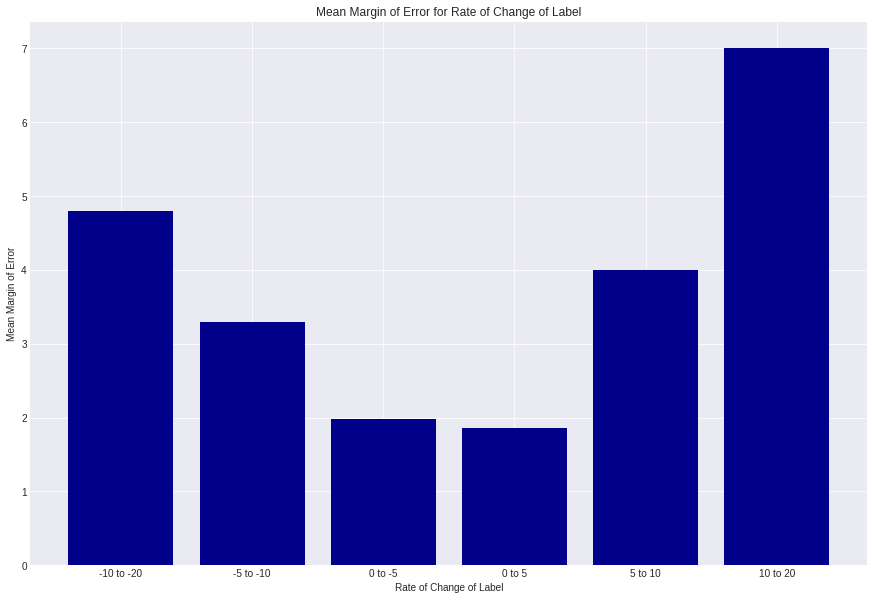

In [ ]:
# In this section, I plot multiple graphs that dislay different aspects of how the predictions operate
margin_err = []
margin_err_dict = {}

for i in range(len(results)):
  diff = abs(results['Label'][i] - results['YHat'][i])
  margin_err.append(diff)

for i in range(len(results)):
  if results['Label'][i] in margin_err_dict:
    margin_err_dict[results['Label'][i]].append(results['YHat'][i] - results['Label'][i])
  else:
    margin_err_dict[results['Label'][i]] = [results['YHat'][i] - results['Label'][i]]


for day, error_list in margin_err_dict.items():
  mean = statistics.mean(error_list)
  margin_err_dict[day] = mean

plt.figure(figsize=(15,10))
plt.style.use(['seaborn-darkgrid'])
plt.plot(results['Label'], color="crimson", label="Actual Patient Count")
plt.plot(margin_err, color="darkblue", label="Margin of Error")

# Displays both the label data and the margin of errors on the predicted results without a histogram
plt.xlabel("Day")
plt.ylabel("Patient Count")
plt.title("Label Data and Margin of Error for Predictions")
plt.legend(loc="upper right")


# This next graph displays all of the predictions errors of margin for each day, where
# a line depicts how far off the prediction was from the actual label data point.
days = range(len(results['Label']))
print(days)
plt.figure(figsize=(15,10))
plt.errorbar(days, results['Label'], yerr=margin_err, fmt='.k', ecolor="teal");
plt.title("Margin of Error for Each Day")

margin_lists = sorted(margin_err_dict.items()) 
count, margin = zip(*margin_lists) 

# Depicts what the mean of all of the margin of errors are for each count (i.e.
# what the mean margin of error is for days with 10 patient intakes, etc)
plt.figure(figsize=(15,10))
plt.title("Mean Margin of Error for Each Label")
plt.bar(count, margin, color="darkblue")
plt.xlabel('Patient Label')
plt.ylabel('Mean Margin of Error')


# The same as above, except it displays the mean margin of error for 
# rate of change between patient intakes
results['Label Change'] = results['Label'].diff()
plt.figure(figsize=(15,15))
plt.title("Rate of Change of Counts Mapped to Margin of Error and Prediction Results")
plt.plot(results['Label Change'], color="red", label="Change of Counts")
plt.plot(margin_err, color="green", label="Margin of Error")
plt.plot(hist_adjusted_results, color="darkblue", label="Prediction")
plt.legend(loc="upper right")


rate_change_dict = {
    "-10 to -20": [],
    "-5 to -10": [],
    "0 to -5": [],
    "0 to 5": [],
    "5 to 10": [],
    "10 to 20": []
}

for i in range(len(results['Label Change'])):
  label_change = results['Label Change'][i]
  if isinstance(label_change, float):
    if 0 <= label_change <= 5:
      rate_change_dict["0 to 5"].append(margin_err[i])
    elif 5 < label_change <= 10:
      rate_change_dict["5 to 10"].append(margin_err[i])
    elif 10 < label_change:
      rate_change_dict["10 to 20"].append(margin_err[i])
    elif 0 > label_change >= -5:
      rate_change_dict["0 to -5"].append(margin_err[i])
    elif 5 > label_change >= -10:
      rate_change_dict["-5 to -10"].append(margin_err[i])
    else:
      rate_change_dict["-10 to -20"].append(margin_err[i])

rate_margin_err = {}
for rate_change, error_list in rate_change_dict.items():
  mean = statistics.mean(error_list)
  rate_margin_err[rate_change] = mean

# Additional graph for displaying rate of change in connection to margins of error
range_rate, margin = zip(*rate_margin_err.items()) 
plt.figure(figsize=(15,10))
plt.title("Mean Margin of Error for Rate of Change of Label")
plt.bar(range_rate, margin, color="darkblue")
plt.xlabel('Rate of Change of Label')
plt.ylabel('Mean Margin of Error')

plt.show()

11
[ 7  8  4 ...  3  6 11]
[ 7  8  4  3  4  9  4  2  3  6  7  6  3  2  3  1  8 11  7  4  0  4  2  2
  1  0  8  2  7  3]


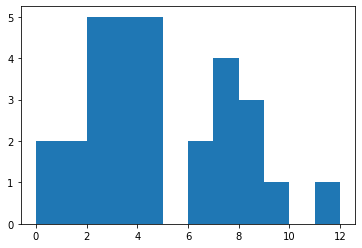

[ 7  8  4  3  4  9  4  2  3  6  7  6  3  2  3  1  8 11  7  4  0  4  2  2
  1  0  8  2  7  3]


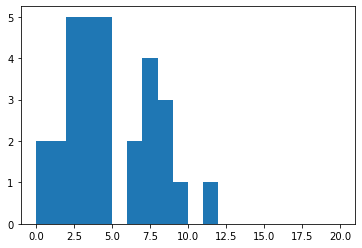

label: 7
yhat:5.1381
bin value of value: 0.0
[ 8  3  7  9  8  6  1  9  5  8  8 10  6  2  5  5  9  9  6  3  1  8  3  7
  4 11  6  3  6  9]


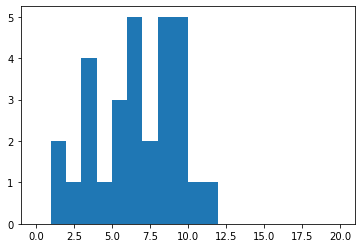

label: 8
yhat:7.1537
bin value of value: 2.0
[16 10  4 11 12  7 10  7 11  4  9  3  6 12 10  9  6  7  6  9  1  4  4  5
 10  5  9  5 13  4]


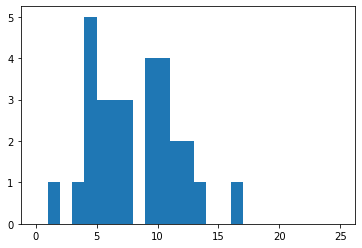

label: 9
yhat:7.5414
bin value of value: 0.0
[ 6  5  7  4  6 12  9  3  7  6  4  8 16 10  5 12  8  5  8  6 13  9  3  2
 17  9  7 11  8  1]


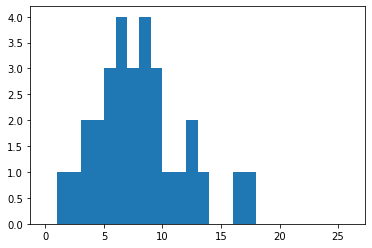

label: 4
yhat:5.1395
bin value of value: 3.0
[ 8  3  4  7  5  6  5  1  7  3  7  1  5  4  9  7 10  2 11 10  5  4  4  2
  5  9  5  6  7  9]


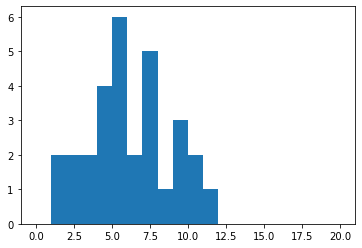

label: 7
yhat:3.7938
bin value of value: 4.0
[ 5  8  6  9  9  5  8  5 10  9  6 16  9  7  9  9 15 17 11  7  1  6  9 10
  8  9  6  6  8  7]


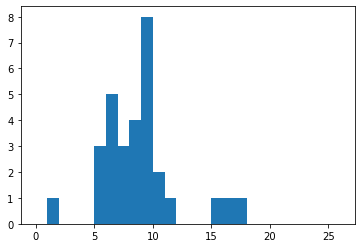

label: 6
yhat:8.3019
bin value of value: 4.0
[ 5  7  7  9  8  8  6 13 13 10  9  7  8 14 16  8 10 12  9  8 10  8 12  7
  7 10 11 13  9  4]


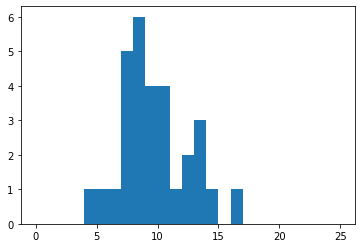

label: 9
yhat:9.6311
bin value of value: 4.0
[ 4  8  4  6  9  2  7  8 10  4  6  6 14  7  6  7  9  9  5 15  5  9 12  6
  4  8  6 10  3 17]


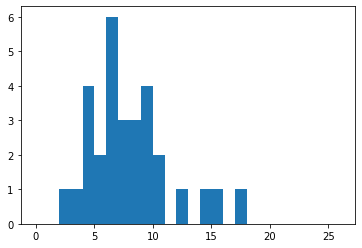

label: 6
yhat:5.4127
bin value of value: 2.0
[ 4  7  6  6  5 11  7  4  7 12  7  9 11 13  9  9 15  8  9  7  7  7 13 11
 10 15  9  9 12  9]


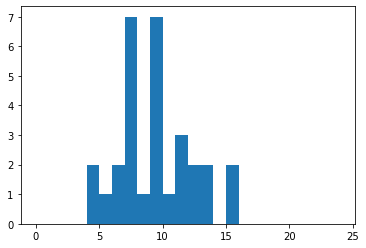

label: 7
yhat:8.3569
bin value of value: 1.0
[ 1  9  3  7 11  7  8  4  6  5  6  9  6 13 12 13  6  6  5  7  6  6  6  6
  7 13  8 16  9  8]


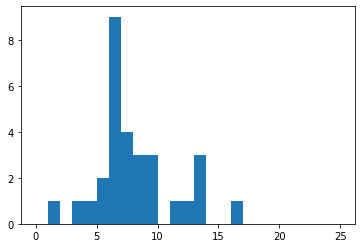

label: 6
yhat:4.8716
bin value of value: 2.0
[11  7 12 12  2 17 18 14  7 15 10  9 13 14  9 10  9  8  9 14 14 10  6 12
  7  2  5 12  6  8]


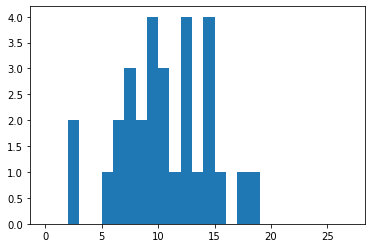

label: 10
yhat:9.0298
bin value of value: 4.0
[ 9  5 11  6  9  5 10  6  6  7  8  7  7  6  8  5  8  5 10  5  6  8  7  4
  9  5  8  3  6 11]


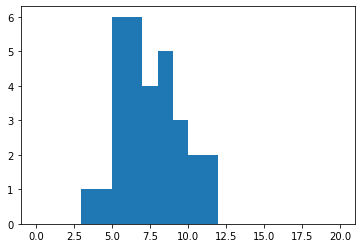

label: 8
yhat:6.7524
bin value of value: 4.0
[ 3  5  8  8 10 14 10 10 14 15  6  6 11  6  7  9  7 11  5 14  4 12 10  9
 13  4  3 13 10  3]


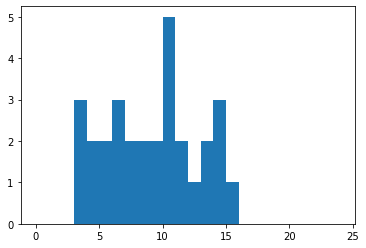

label: 6
yhat:9.5505
bin value of value: 5.0
[20 20 21 14  9 10  8 16  9 18  9  6  9  7 13 14 21 12 15  8 14 11  6 10
 14  8 15  6 14  9]


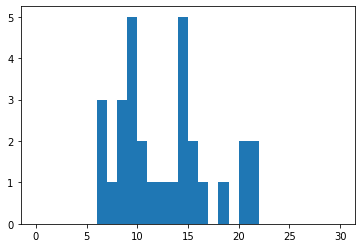

label: 9
yhat:11.097
bin value of value: 1.0
[11  8 14 11 17 19 11  8  7 17 10  6  7  9  9  8 15 14 14 10  7 11  6 14
 10  6 16 15  5 14]


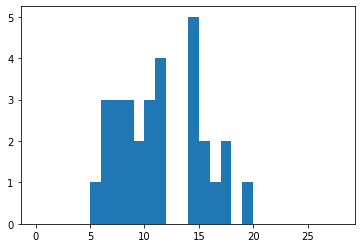

label: 10
yhat:8.9266
bin value of value: 2.0
[10  5  8  3 10 13  8 11  6  3 12  7 14 17 12  8  8  8 11  6  8  7  9 10
  7 11  7  6 10  5]


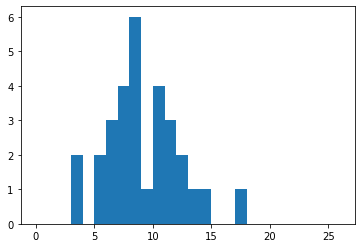

label: 12
yhat:7.9744
bin value of value: 6.0
[ 9 11  9 12  8 10 10  1 10 11  9  6  3  7  7 13 10  9 11 10  9  8  6  5
 12 12 10  9  8 14]


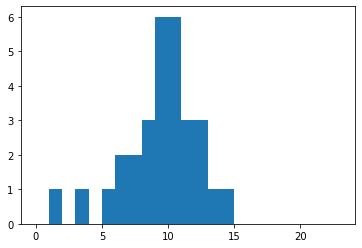

label: 9
yhat:7.6285
bin value of value: 3.0
[10 10  9 14  9  9 10 10 15 21  8 12  7 14 11 11 19 13 11 13 16 12 10  7
 10  7 15 12  9 16]


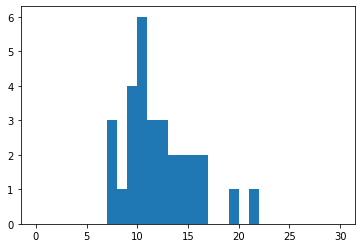

label: 8
yhat:15.196
bin value of value: 2.0
[ 8 10  8 12  7 18  9  5 11 17 11  5  5 11  5  9  5 11 12 17 11  8  4  8
 11 10 11 14 11 12]


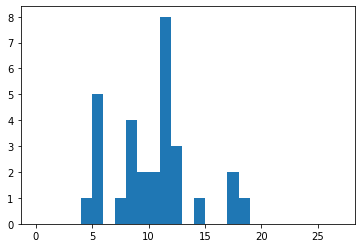

label: 11
yhat:9.5443
bin value of value: 2.0
[ 7  8  8  6  9 13  5 14  8  7  8  9  8  6  7  6 10 14 14  9 10 16 19 12
 15 12 12 21 13 16]


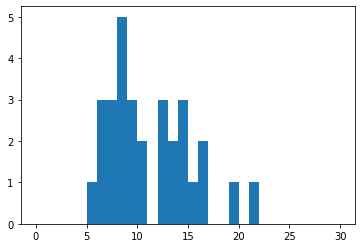

label: 8
yhat:8.8698
bin value of value: 3.0
[11 12  7 12  7 11 10 11 10  9 13 11 16  9  7  9 14 11 10 11  9 11 13 13
 17 16 14 16 13 11]


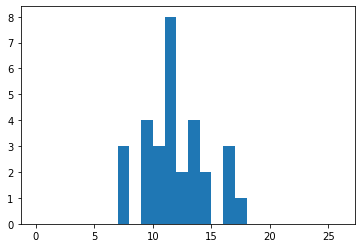

label: 13
yhat:10.42
bin value of value: 3.0
[13 14 11 13  6 14 17 14 11  8 12 12 16 20 20 11 17 17  8  8 15 14 11 10
 13 18 20 13 11 12]


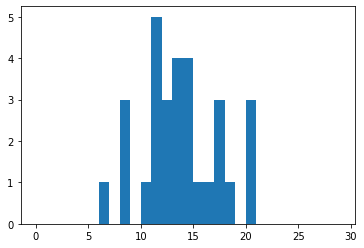

label: 12
yhat:9.9158
bin value of value: 1.0
[ 8  9  9 11 12 10  8 10  9 10  8  9  6 12 13 12  6 15  7  8 12 12 13  6
 13  3 13 10  5 10]


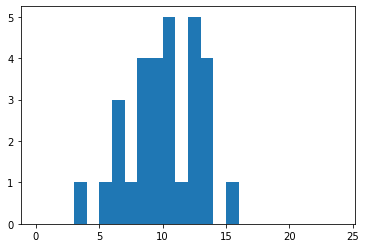

label: 8
yhat:9.7159
bin value of value: 5.0


In [ ]:
# This code snippet displays some of the histograms in 30 day periods for visualization purposes

# histogram adjustment
max_patient_count = 30
hist_weight_adj = 0.5
historical_set = 30


patien_set = patient_count[:historical_set] # set initial historical data

(n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 2, 1))


plt.show()

for i in range(len(patient_count) - historical_set):
  if i % 100 == 0:
    patien_set = patient_count[i:historical_set + i]
    (n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 10, 1))
    print(patien_set)
    plt.show()

    print('label: ' + str(results['Label'][i]))
    print('yhat:' + str(results['YHat'][i]))
    print('bin value of value: ' + str(n[round(results['YHat'][i])]))